In [ ]:
"""
    This is a toy example that demonstrates how we can use LRP on a convolutional neural network trained on mnist
"""

%matplotlib inline
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
from tqdm import tnrange, tqdm_notebook
import lrp
import pandas as pd
from pylab import rcParams
import os
rcParams['figure.figsize'] = 8, 10


In [ ]:
mnist = input_data.read_data_sets(os.path.expanduser('~/mnist-data'))

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=True

In [24]:
#Build the Convolutional Neural Network
batch_size = 50
total_batch = int(mnist.train.num_examples/batch_size)
num_epochs = 5

with tf.device('/device:GPU:0'):

    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10], name="truth")

    #Set the weights for the network
    xavier = tf.contrib.layers.xavier_initializer_conv2d()  
    conv1_weights = tf.get_variable(name="c1", initializer=xavier, shape=[5, 5, 1, 10])
    conv1_biases = tf.Variable(tf.zeros([10]))
    conv2_weights = tf.get_variable(name="c2", initializer=xavier, shape=[5, 5, 10, 25])
    conv2_biases = tf.Variable(tf.zeros([25]))
    conv3_weights = tf.get_variable(name="c3", initializer=xavier, shape=[4, 4, 25, 100])
    conv3_biases = tf.Variable(tf.zeros([100]))
    fc1_weights = tf.Variable(tf.truncated_normal([4 * 4 * 100, 10], stddev=0.1))
    fc1_biases = tf.Variable(tf.zeros([10]))

    #Stack the Layers
    reshaped_input = tf.reshape(x, [-1, 28, 28, 1], name="absolute_input")
    #layer 1
    conv1 = tf.nn.conv2d(reshaped_input, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
    pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],  padding='SAME')
    #layer 2
    conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
    pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #layer 3
    conv3 = tf.nn.conv2d(pool2, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
    pool3 = tf.nn.max_pool(relu3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #layer 4    
    pool_shape = pool3.get_shape().as_list()
    reshaped = tf.reshape(pool3, [-1, pool_shape[1] * pool_shape[2] * pool_shape[3]])
    y = tf.add(tf.matmul(reshaped, fc1_weights), fc1_biases, name="absolute_output")

    # Define loss and optimizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
    train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)

In [25]:
sess = tf.InteractiveSession(config=config)

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [26]:
# Train the model
sess.run(tf.global_variables_initializer())

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

loss_value = float('nan')
for i in tnrange(num_epochs, desc='Epochs'):
    tbatch = tnrange(total_batch, desc='Batches', leave=False)
    for j in tbatch:
        tbatch.set_postfix(Loss=loss_value)
        tbatch.refresh() # to show immediately the update
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_y = tf.one_hot(batch_y, depth=10).eval()
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})
        loss_value = sess.run(cross_entropy, feed_dict={x: batch_x, y_: batch_y})
        
# Save the variables to disk.
save_path = saver.save(sess, os.path.expanduser('~/model_mnist.ckpt'))
print("Model saved in path: %s" % save_path)

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
test_acc = []
train_acc = []
for i in tnrange(total_batch):
    batch_x, batch_y = mnist.test.next_batch(batch_size)
    batch_y = tf.one_hot(batch_y, depth=10).eval()
    test_acc.append(sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y}))
    
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_y = tf.one_hot(batch_y, depth=10).eval()
    train_acc.append(sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y}))
    
print('Train accuracy={train_acc:3.3f}, test accuracy={test_acc:3.3f}'.format(
    train_acc=np.mean(train_acc), test_acc=np.mean(test_acc)))

Model saved in path: /mnt/students-home/test-student/model_mnist.ckpt


Train accuracy=0.995, test accuracy=0.991


**Be sure to run "#Build the Convolutional Neural Network" cell before** -- TF needs to create the variables first, and then their values can be restored.

In [29]:
saver = tf.train.Saver()

load_path = saver.restore(sess, os.path.expanduser('~/model_mnist.ckpt'))
print("Model restored from path: %s" % load_path)

INFO:tensorflow:Restoring parameters from /mnt/students-home/test-student/model_mnist.ckpt
Model restored from path: None


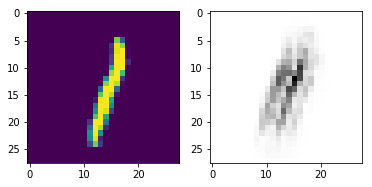

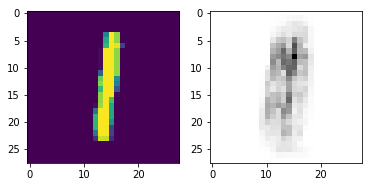

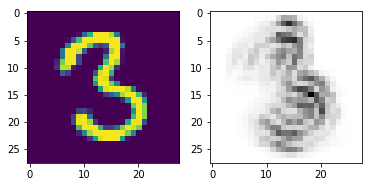

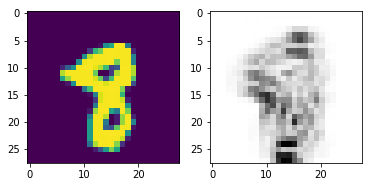

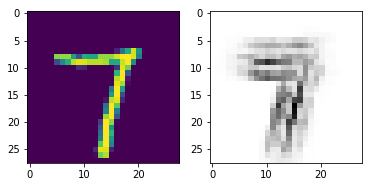

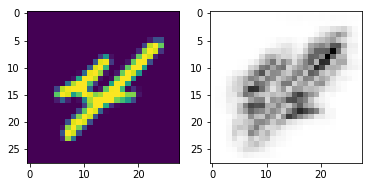

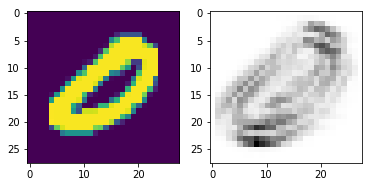

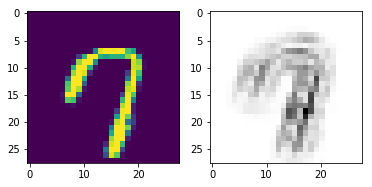

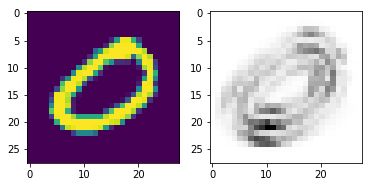

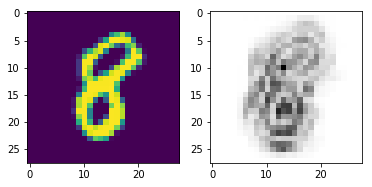

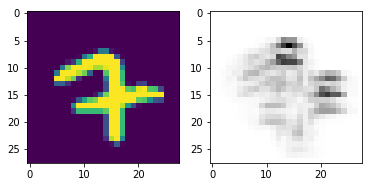

KeyboardInterrupt: 

In [30]:
#Run LRP with Deep Taylor Decomposition on the output of the network
F_list = lrp.lrp(y * y_, 0, 1, return_flist=True)
im_list = lrp.get_lrp_im(sess, F_list[-1], reshaped_input, y_, np.reshape(batch_x, (batch_size, 28,28, 1)), batch_y)
#Visualize the produced heatmaps
for b, im in zip(batch_x, im_list):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(b, (28,28)))
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(im, (28,28)), cmap="gray")
    plt.show()